In [47]:
import torch
from architecture import resnet50
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [48]:
# load classes names
with open('sets/classes.txt', 'r') as f:
    classes = [l.strip() for l in f.readlines()]
print('Loaded {} classes:'.format(len(classes)))
print('\n'.join(classes))

Loaded 10 classes:
11H(ANTONY OF PADUA)
11H(JOHN THE BAPTIST)
11H(PAUL)
11H(FRANCIS)
11HH(MARY MAGDALENE)
11H(JEROME)
11H(DOMINIC)
11F(MARY)
11H(PETER)
11H(SEBASTIAN)


In [49]:
import torch
x = torch.rand(5, 3)
print(x)
print(torch.version.cuda)
print(torch.backends.cudnn.enabled)
torch.cuda.is_available()

tensor([[0.9467, 0.1151, 0.6706],
        [0.9441, 0.7712, 0.9092],
        [0.0851, 0.1713, 0.5103],
        [0.4156, 0.0068, 0.8268],
        [0.3975, 0.5887, 0.8051]])
10.2
True


True

In [50]:
# initialize model
num_classes = 10
model = resnet50.CAM(num_classes)
print(model)

CAM(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FixedBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FixedBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [51]:
# load weights
weights_path = 'model/res50.pth'
model.load_state_dict(torch.load(weights_path), strict=True)
print('Model loaded')

Model loaded


In [52]:
# set model to be run on GPU
model.cuda()
# set model to run on eval mode
model.eval()

In [53]:
def normalize_img(img):
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    imgarr = np.asarray(img) / 255
    
    proc_img = np.empty_like(imgarr, np.float32)
    proc_img[..., 0] = (imgarr[..., 0] - mean[0]) / std[0]
    proc_img[..., 1] = (imgarr[..., 1] - mean[1]) / std[1]
    proc_img[..., 2] = (imgarr[..., 2] - mean[2]) / std[2]

    return proc_img

def HWC_to_CHW(img):
    return np.transpose(img, (2, 0, 1))

(898, 600)
Image size: (898, 600)


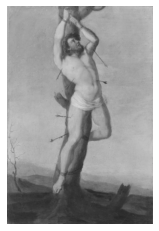

In [54]:
# load img
img_path = 'test-data/Q18599229.jpg'
orig_img = np.asarray(imageio.imread(img_path))
img_size = orig_img.shape[:2]
print('Image size:', img_size)
# show img
plt.imshow(orig_img)
plt.axis('off')
plt.show()

In [40]:
# normalize img based on imagenet std and mean
img = normalize_img(orig_img)
# transpose channel to have (3, H, W)
img = HWC_to_CHW(img)
# add batch to dimensions
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 3, 898, 600)


In [41]:
# numpy to pytorch tensor
img = torch.from_numpy(img)
# load image on gpu
img = img.cuda()

In [42]:
# get CAMS from img
cams = model(img)
print(cams.shape)

torch.Size([1, 10, 57, 38])


In [43]:
high_res_cams = F.interpolate(cams, img_size, mode='bilinear', align_corners=False)
print(high_res_cams.shape)

torch.Size([1, 10, 898, 600])


In [44]:
# remove batch dimensions from cams
cams = torch.squeeze(cams, 0)
high_res_cams = torch.squeeze(high_res_cams, 0)
print(cams.shape)
print(high_res_cams.shape)

torch.Size([10, 57, 38])
torch.Size([10, 898, 600])


In [46]:
# min-max normalization
cams /= F.adaptive_max_pool2d(cams, (1, 1)) + 1e-5
high_res_cams /= F.adaptive_max_pool2d(high_res_cams, (1, 1)) + 1e-5
# torch to numpy
cams = cams.data.cpu().numpy()
high_res_cams = high_res_cams.data.cpu().numpy()

print(high_res_cams.shape)
print(np.min(high_res_cams))
print(np.max(high_res_cams))

(10, 898, 600)
0.0
1.0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


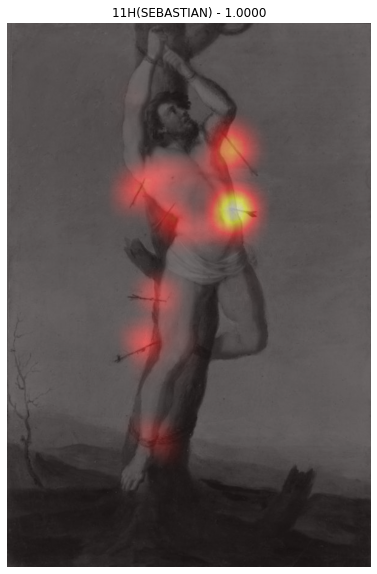

In [16]:
# showing only cam of class with predicted prob > 0.5
# predictions are obtained from classification notebook
preds = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
# predictions < 0.5 are set to 0
preds = (preds >= 0.5) * preds

for i in preds.nonzero()[0]:
    class_name = classes[i]
    prob = preds[i]
    print(high_res_cams[i])
    
    plt.figure(figsize=(10,10))
    plt.imshow(orig_img)
    plt.imshow(high_res_cams[i], cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('{} - {:.4f}'.format(class_name, prob))
    plt.show()

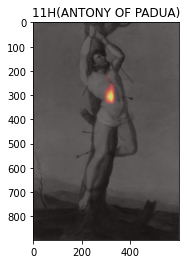

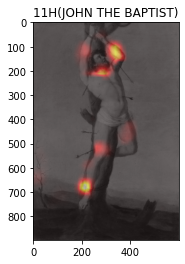

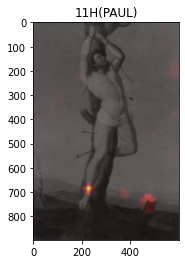

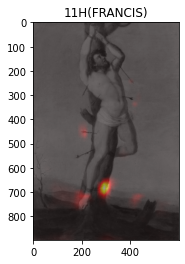

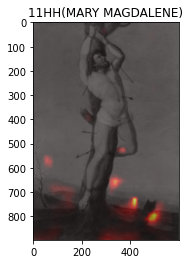

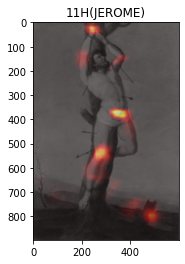

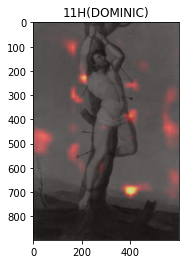

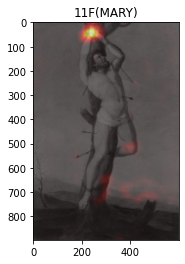

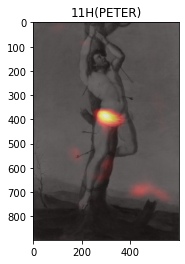

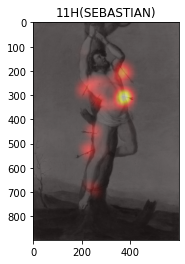

In [17]:
# highres cams of all classes
for i, c in enumerate(classes):
    plt.imshow(orig_img)
    plt.imshow(high_res_cams[i], cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
    plt.title(c)
    plt.show()